**Chapter 3 – Classification**

_This notebook contains all the sample code and solutions to the exercises in chapter 3._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/03_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

**Warning:** since Scikit-Learn 0.24, `fetch_openml()` returns a Pandas `DataFrame` by default. To avoid this and keep the same code as in the book, we use `as_frame=False`.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

In [5]:
28 * 28

784

Saving figure some_digit_plot


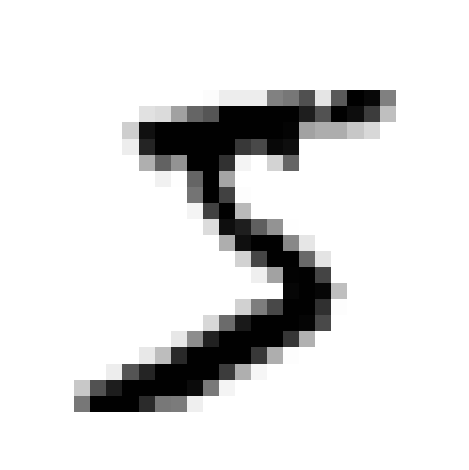

In [6]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [7]:
y[0]

'5'

In [8]:
y = y.astype(np.uint8)

In [9]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [10]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


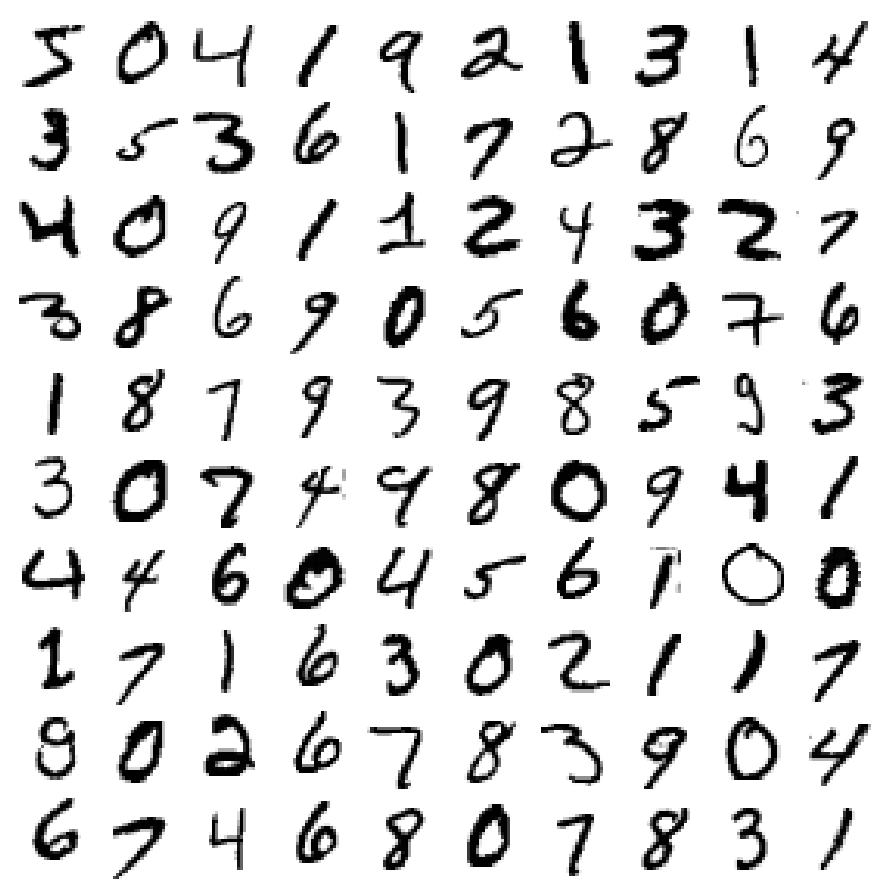

In [11]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [12]:
y[0]

5

In [13]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

**Note**: some hyperparameters will have a different defaut value in future versions of Scikit-Learn, such as `max_iter` and `tol`. To be future-proof, we explicitly set these hyperparameters to their future default values. For simplicity, this is not shown in the book.

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [16]:
sgd_clf.predict([some_digit])

array([ True])

In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

# Performance Measures

## Measuring Accuracy Using Cross-Validation

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


**Note**: `shuffle=True` was omitted by mistake in previous releases of the book.

In [19]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [20]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

**Warning**: this output (and many others in this notebook and other notebooks) may differ slightly from those in the book. Don't worry, that's okay! There are several reasons for this:
* first, Scikit-Learn and other libraries evolve, and algorithms get tweaked a bit, which may change the exact result you get. If you use the latest Scikit-Learn version (and in general, you really should), you probably won't be using the exact same version I used when I wrote the book or this notebook, hence the difference. I try to keep this notebook reasonably up to date, but I can't change the numbers on the pages in your copy of the book.
* second, many training algorithms are stochastic, meaning they rely on randomness. In principle, it's possible to get consistent outputs from a random number generator by setting the seed from which it generates the pseudo-random numbers (which is why you will see `random_state=42` or `np.random.seed(42)` pretty often). However, sometimes this does not suffice due to the other factors listed here.
* third, if the training algorithm runs across multiple threads (as do some algorithms implemented in C) or across multiple processes (e.g., when using the `n_jobs` argument), then the precise order in which operations will run is not always guaranteed, and thus the exact result may vary slightly.
* lastly, other things may prevent perfect reproducibility, such as Python dicts and sets whose order is not guaranteed to be stable across sessions, or the order of files in a directory which is also not guaranteed.

## Confusion Matrix

In [21]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [23]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

<Figure size 800x600 with 0 Axes>

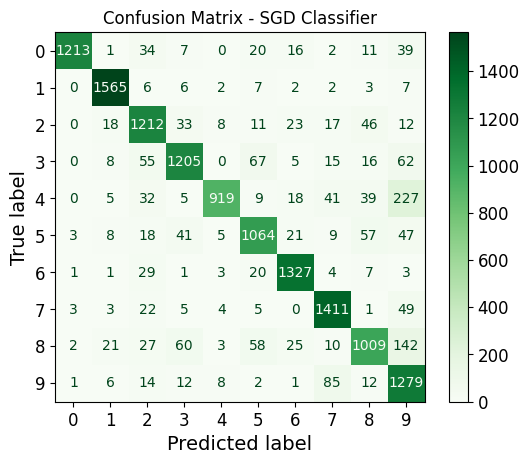

In [76]:
# Step 1: Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 2: Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"]

# Convert the target variable to integers (from string to int)
y = y.astype(np.int8)

# Step 3: Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Initialize the SGD Classifier
sgd_clf = SGDClassifier(random_state=42)

# Step 5: Train the classifier on the training data
sgd_clf.fit(X_train, y_train)

# Step 6: Make predictions on the test data
y_pred = sgd_clf.predict(X_test)

# Step 7: Evaluate the model's accuracy
#accuracy = accuracy_score(y_test, y_pred)
#print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

# Step 8: Generate and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 9: Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')
plt.title(f"Confusion Matrix - SGD Classifier" )#(Accuracy: {accuracy * 100:.2f}%)")
plt.show()

# Check if accuracy reaches 91.5%
#if accuracy >= 0.915:
   # print("Achieved target accuracy of 91.5%!")
#else:
    #print("Target accuracy of 91.5% not reached.")


## Precision and Recall

In [24]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [25]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [26]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [27]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

In [28]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [29]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

## Precision/Recall Trade-off

In [30]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [31]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [32]:
y_some_digit_pred

array([ True])

In [33]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [34]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [35]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


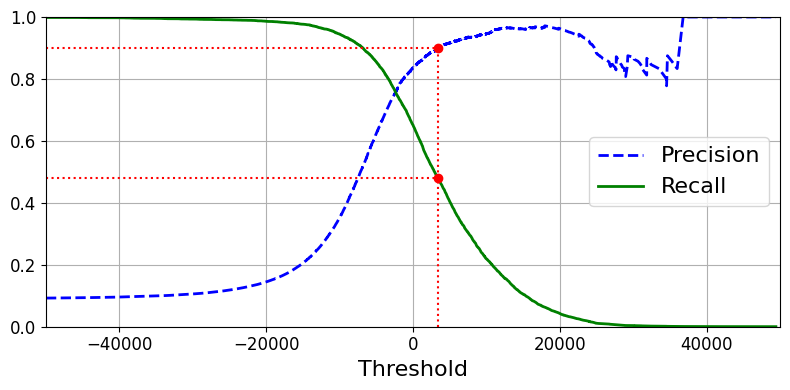

In [36]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

In [37]:
(y_train_pred == (y_scores > 0)).all()

True

Saving figure precision_vs_recall_plot


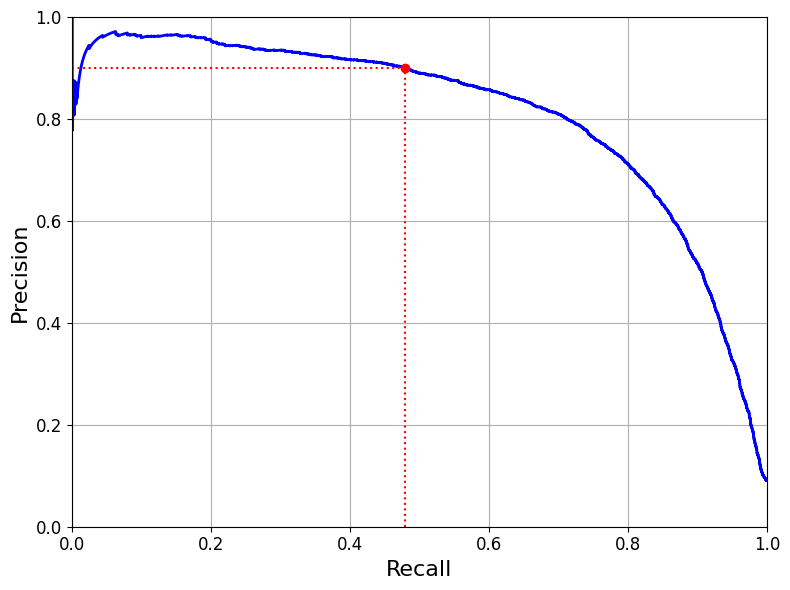

In [38]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [39]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [40]:
threshold_90_precision

3370.0194991439557

In [41]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [42]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [43]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## The ROC Curve

In [44]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


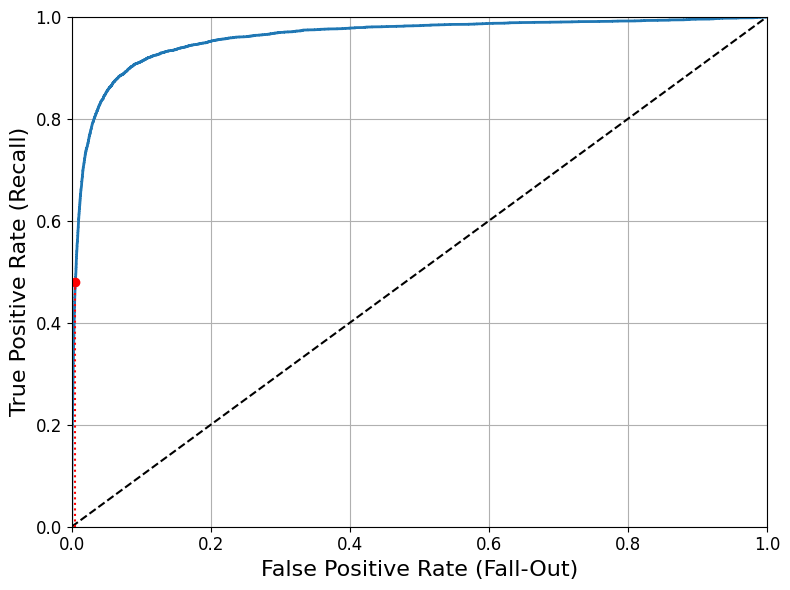

In [45]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

In [46]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**Note**: we set `n_estimators=100` to be future-proof since this will be the default value in Scikit-Learn 0.22.

In [47]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [48]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Saving figure roc_curve_comparison_plot


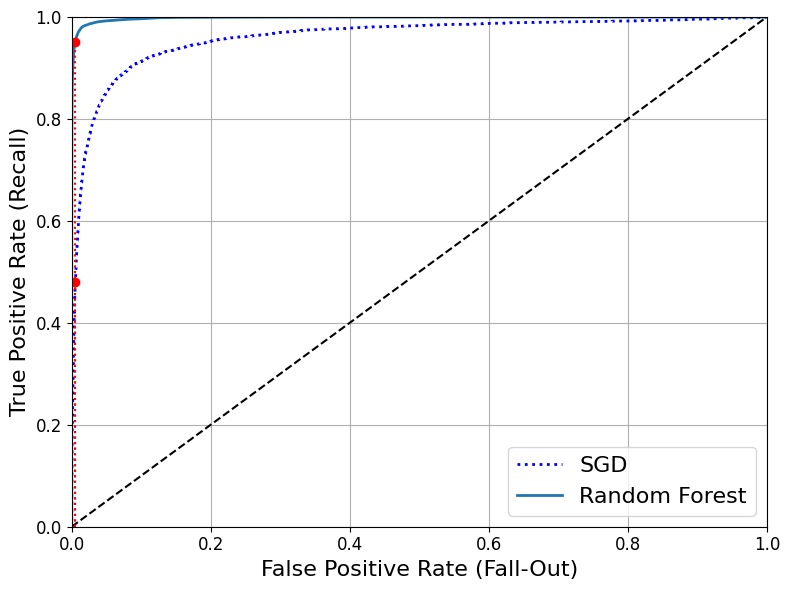

In [49]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [50]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [51]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [52]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

Accuracy on the test set: 96.73%


<Figure size 800x600 with 0 Axes>

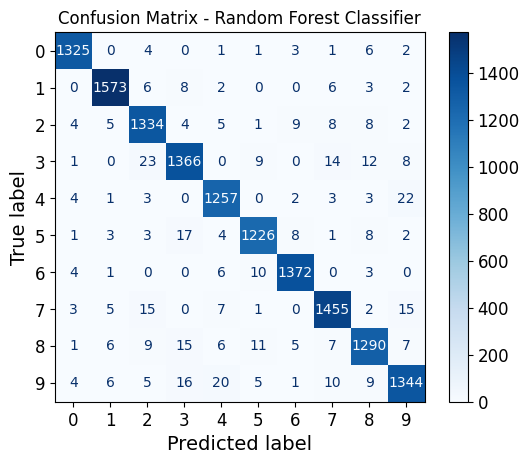

Target accuracy of 96.8% not reached.


In [80]:
# Step 1: Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Step 2: Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"]

# Convert the target variable to integers (from string to int)
y = y.astype(np.int8)

# Step 3: Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Initialize the Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Step 5: Train the Random Forest classifier on the training data
rf_clf.fit(X_train, y_train)

# Step 6: Make predictions on the test data
y_pred = rf_clf.predict(X_test)

# Step 7: Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

# Step 8: Generate and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 9: Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix - Random Forest Classifier")
plt.show()

# Check if accuracy reaches 96.8%
if accuracy >= 0.968:
    print("Achieved target accuracy of 96.8%!")
else:
    print("Target accuracy of 96.8% not reached.")


# Multilabel Classification

In [53]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [54]:
knn_clf.predict([some_digit])

array([[False,  True]])

**Warning**: the following cell may take a very long time (possibly hours depending on your hardware).

In [55]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

# Multioutput Classification

In [56]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Saving figure noisy_digit_example_plot


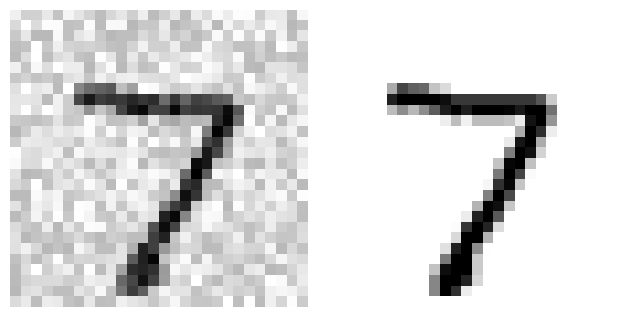

In [57]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

Saving figure cleaned_digit_example_plot


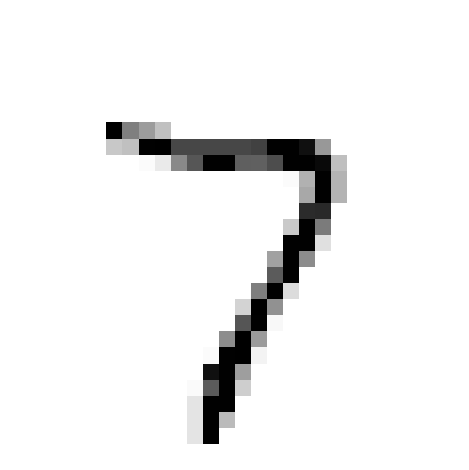

In [58]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

# Extra material

## KNN classifier

In [61]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [62]:
y_knn_pred = knn_clf.predict(X_test)

In [63]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

<ipython-input-64-d24610df8b88>:1: DeprecationWarning: Please import `shift` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import shift


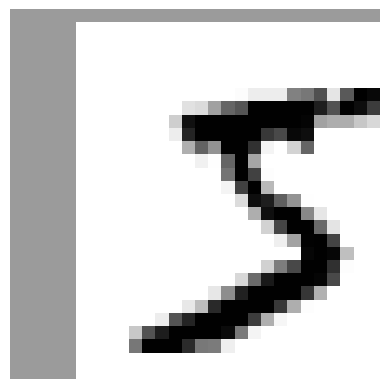

In [64]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [65]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [66]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [67]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [68]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [69]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.24579675, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.75420325]])

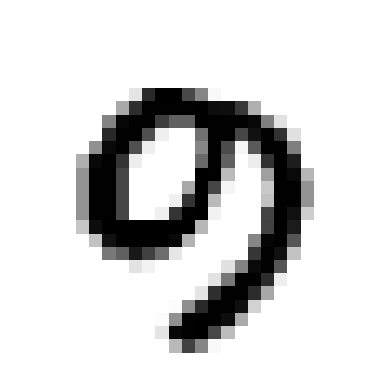

In [70]:
plot_digit(ambiguous_digit)

## 1. An MNIST Classifier With Over 97% Accuracy

**Warning**: the next cell may take close to 16 hours to run, or more depending on your hardware.

In [75]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.972 total time=  39.2s
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.971 total time=  40.6s
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  39.3s
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  38.9s
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.970 total time=  38.0s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  38.5s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  38.8s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  38.1s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  40.2s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.971 total time=  37.3s
[CV 1/5] END ....n_neighbors=4, weights=uniform;, score=0.969 total time=  40.1s
[CV 2/5] END ....n_neighbors=4, weights=uniform;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [ ]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [ ]:
grid_search.best_score_

0.9716166666666666

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

## 2. Data Augmentation

In [ ]:
from scipy.ndimage.interpolation import shift

In [ ]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

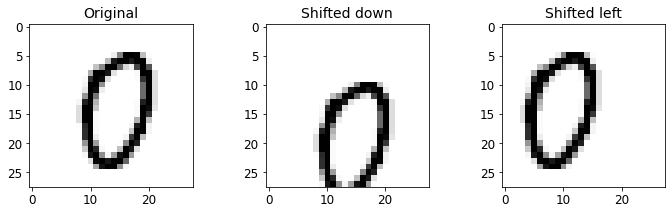

In [ ]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [ ]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [ ]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [ ]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [ ]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

**Warning**: the following cell may take close to an hour to run, depending on your hardware.

In [ ]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763

Accuracy on the test set: 97.13%


<Figure size 800x600 with 0 Axes>

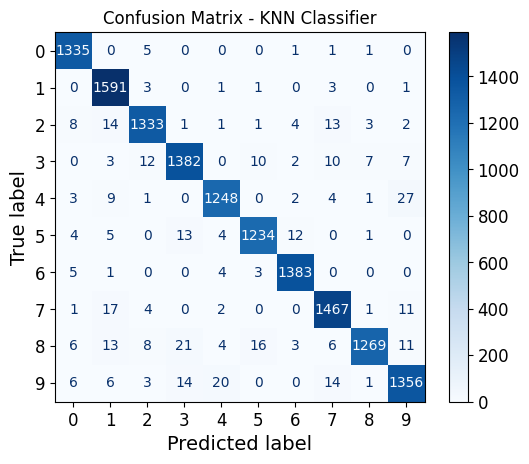

Target accuracy of 97.2% not reached.


In [79]:
# Step 1: Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Ensure matplotlib plots inline for Jupyter Notebooks
# Uncomment this line if using Jupyter:
# %matplotlib inline

# Step 2: Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"]

# Convert the target variable to integers (from string to int)
y = y.astype(np.int8)

# Step 3: Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Initialize the KNN Classifier with k=3 (or a value that gives good performance)
knn_clf = KNeighborsClassifier(n_neighbors=3)

# Step 5: Train the KNN classifier on the training data
knn_clf.fit(X_train, y_train)

# Step 6: Make predictions on the test data
y_pred = knn_clf.predict(X_test)

# Step 7: Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

# Step 8: Generate and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Clear any existing figures
plt.clf()
plt.close('all')

# Step 9: Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix - KNN Classifier")
plt.show()

# Optional: Save confusion matrix figure as an image
# plt.savefig('confusion_matrix.png')

# Check if accuracy reaches 97.2%
if accuracy >= 0.972:
    print("Achieved target accuracy of 97.2%!")
else:
    print("Target accuracy of 97.2% not reached.")


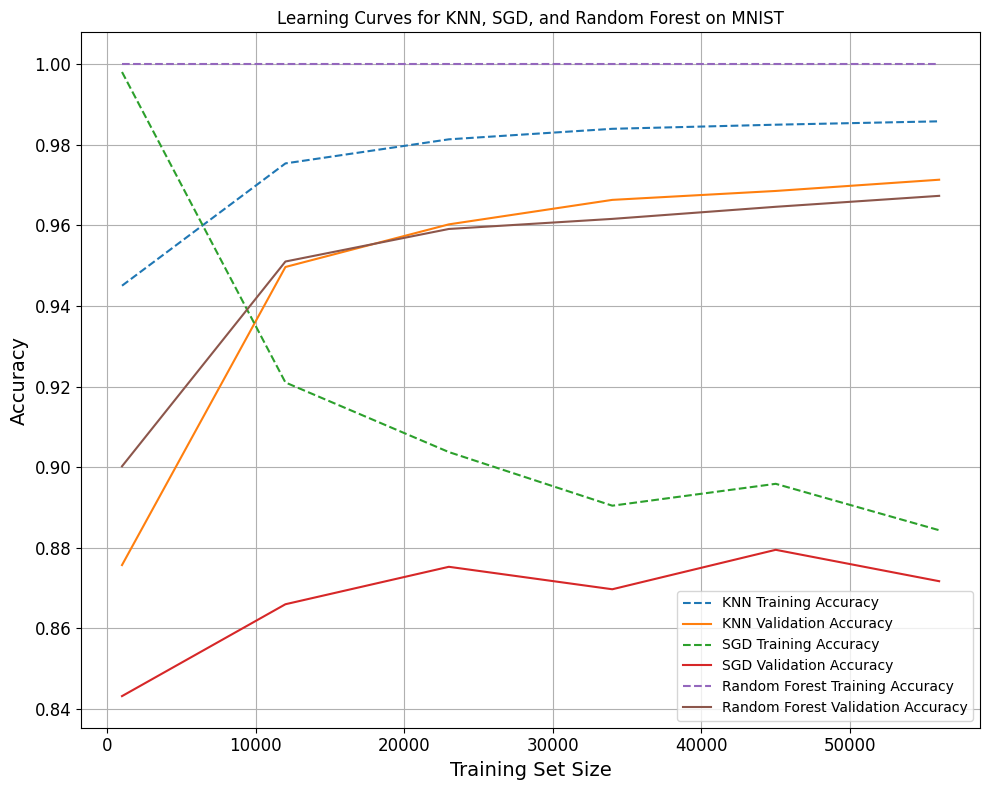

In [81]:
# Step 1: Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

# Step 2: Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"]

# Convert the target variable to integers (from string to int)
y = y.astype(np.int8)

# Step 3: Split the dataset into training and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Define the classifiers
classifiers = {
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "SGD": SGDClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
}

# Step 5: Define the function to calculate learning curves
def plot_learning_curves(classifiers, X_train_full, y_train_full, X_test, y_test):
    # Arrays to store the number of training samples to evaluate on
    train_sizes = np.linspace(1000, len(X_train_full), 6, dtype=int)  # Choose 6 different sizes for plotting
    plt.figure(figsize=(10, 8))

    # Loop through each classifier
    for name, clf in classifiers.items():
        train_acc, val_acc = [], []

        # For each training set size, fit the model and evaluate accuracy
        for size in train_sizes:
            X_train_subset = X_train_full[:size]
            y_train_subset = y_train_full[:size]

            clf.fit(X_train_subset, y_train_subset)
            y_train_pred = clf.predict(X_train_subset)
            y_test_pred = clf.predict(X_test)

            train_acc.append(accuracy_score(y_train_subset, y_train_pred))
            val_acc.append(accuracy_score(y_test, y_test_pred))

        # Plot training and validation accuracy for each classifier
        plt.plot(train_sizes, train_acc, label=f"{name} Training Accuracy", linestyle="--")
        plt.plot(train_sizes, val_acc, label=f"{name} Validation Accuracy")

    # Add labels, legend, and title
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.title("Learning Curves for KNN, SGD, and Random Forest on MNIST")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Step 6: Call the function to plot the learning curves
plot_learning_curves(classifiers, X_train_full, y_train_full, X_test, y_test)
